# Running YOLOv3 Models on an Image
## This code is written for educational purpose (UM Surabaya Proffesional Ethics)

In [2]:
from sys import platform
from models import *
from utils.datasets import *
from utils.utils import *
import matplotlib.pyplot as plt

In [3]:
class inf_option:
    def __init__(self, names):
        self.cfg = 'cfg/yolov3-tiny3.cfg'
        self.names  = [names]
        self.conf_thres = 0.01
        self.iou_thres = 0.4
        self.source = 'tests/'
        self.output = 'output/'
        self.img_size = 320
        self.device = '0'
        if names == 'car':
            self.weights = 'weights/best_car.pt'
        else:
            self.weights = 'weights/best_person.pt'

opt = inf_option('person')


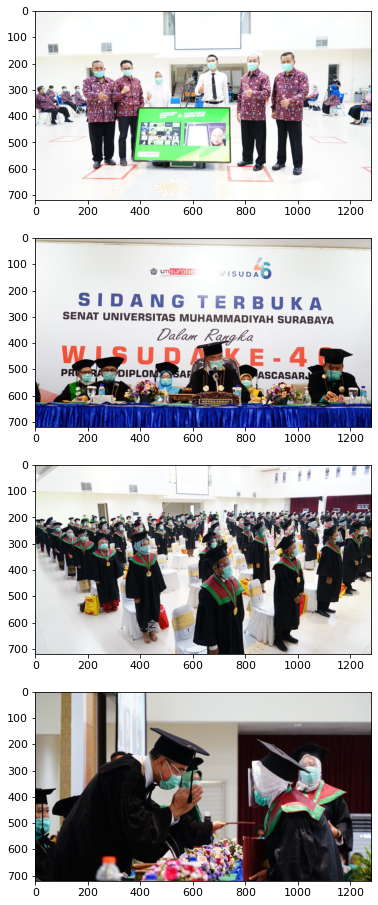

In [4]:
im_count = len([name for name in os.listdir(opt.source) 
                if os.path.isfile(os.path.join(opt.source,name))])
plt.figure(figsize=(32,16))
for i, file in enumerate(os.listdir(opt.source)):
    im_file = os.path.join(opt.source, file)
    im_show = plt.imread(im_file)
    plt.subplot(im_count, 1, i+1)
    plt.imshow(im_show)

In [5]:
def detect(save_img=False):
    img_size = (320, 192) if ONNX_EXPORT else opt.img_size  # (320, 192) or (416, 256) or (608, 352) for (height, width)
    out, source, weights = opt.output, opt.source, opt.weights
   
    # Initialize
    device = torch_utils.select_device(device='cpu' if ONNX_EXPORT else opt.device)
    if os.path.exists(out):
        shutil.rmtree(out)  # delete output folder
    os.makedirs(out)  # make new output folder

    # Initialize model
    model = Darknet(opt.cfg, img_size, strategy='None')
    
    model.load_state_dict(torch.load(weights, map_location=device)['model'])

    # Eval mode
    model.to(device).eval()

    # Set Dataloader
    save_img = True
    dataset = LoadImages(source, img_size=img_size)

    # Get names and colors
    names = opt.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(names))]
    for c in names:
        print(c)

    # Run inference
    t0 = time.time()
    img = torch.zeros((1, 3, img_size, img_size), device=device)  # init img
    _ = model(img.float()) if device.type != 'cpu' else None  # run once
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.float()
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = torch_utils.time_synchronized()
        pred = model(img, augment=False)[0]
        t2 = torch_utils.time_synchronized()

        # Apply NMS
        pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres,
                                   multi_label=False, classes=None)
        
        # Process detections
        for i, det in enumerate(pred):  # detections per image
            p, s, im0 = path, '', im0s

            save_path = str(Path(out) / Path(p).name)
            s += '%gx%g ' % img.shape[2:]  # print string
            if det is not None and len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += '%g %ss, ' % (n, names[int(c)])  # add to string

                # Write results
                for *xyxy, conf, cls in det:
                    if save_img or view_img:  # Add bbox to image
                        label = '%s %.2f' % (names[int(cls)], conf)
                        plot_one_box(xyxy, im0, label=label, color=colors[int(cls)])

            # Print time (inference + NMS)
            print('%sDone. (%.3fs)' % (s, t2 - t1))

            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'images':
                    cv2.imwrite(save_path, im0)

    print('Done. (%.3fs)' % (time.time() - t0))

In [6]:
with torch.no_grad():
        results = detect()

Using CUDA device0 _CudaDeviceProperties(name='GeForce RTX 2060', total_memory=6144MB)

Model Summary: 45 layers, 9.00039e+06 parameters, 9.00039e+06 gradients
person
192x320 19 persons, Done. (0.003s)
192x320 15 persons, Done. (0.003s)
192x320 38 persons, Done. (0.003s)
192x320 4 persons, Done. (0.003s)
Done. (1.191s)


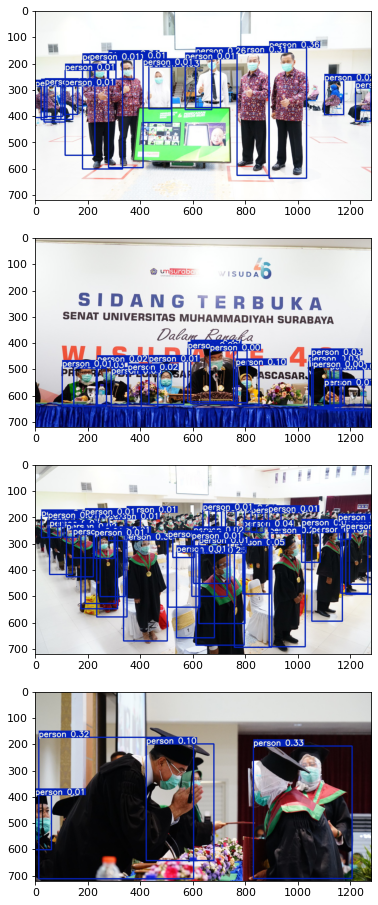

In [7]:
im_count = len([name for name in os.listdir(opt.output) if os.path.isfile(os.path.join(opt.output,name))])
plt.figure(figsize=(32,16))
for i, file in enumerate(os.listdir(opt.output)):
    im_file = os.path.join(opt.output, file)
    im_show = plt.imread(im_file)
    plt.subplot(im_count, 1, i+1)
    plt.imshow(im_show)